<a href="https://colab.research.google.com/github/AviciiKaplan/CPS-4801-Project/blob/main/Final%20Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CNN Model


In [ ]:
#calebs work
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

IMG_SIZE = 224
EPOCHS = 5
BATCH_SIZE = 32

dataset_path = '/content/drive/MyDrive/Skin Cancer'
def load_images(base_dir):
    images, labels = [], []
    for label in ['benign', 'malignant']:
        path = os.path.join(base_dir, label)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    images.append(img)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

train_images, train_labels = load_images(os.path.join(dataset_path, 'train'))
test_images, test_labels = load_images(os.path.join(dataset_path, 'test'))

# Normalize and encode
train_images = train_images / 255.0
test_images = test_images / 255.0

le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
test_labels_enc = le.transform(test_labels)

train_labels_cat = to_categorical(train_labels_enc)
test_labels_cat = to_categorical(test_labels_enc)

# Build CNN
def build_cnn_functional():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', name='feature_layer')(x)  # Name for feature extraction
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_functional()


cnn_model.fit(train_images, train_labels_cat,
              validation_data=(test_images, test_labels_cat),
              epochs=EPOCHS,
              batch_size=BATCH_SIZE)

#CNN Features + SVM
def extract_features(model, data):
    feature_extractor = Model(inputs=model.input, outputs=model.get_layer('feature_layer').output)
    return feature_extractor.predict(data, verbose=1)

X_train_feat = extract_features(cnn_model, train_images)
X_test_feat = extract_features(cnn_model, test_images)

svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_feat, train_labels_enc)


svm_preds = svm.predict(X_test_feat)
print(classification_report(test_labels_enc, svm_preds, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(test_labels_enc, svm_preds))
print("ROC AUC Score:", roc_auc_score(test_labels_enc, svm.predict_proba(X_test_feat)[:, 1]))

Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 48s 562ms/step - accuracy: 0.6071 - loss: 1.7202 - val_accuracy: 0.7697 - val_loss: 0.4285
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 46s 549ms/step - accuracy: 0.7804 - loss: 0.4711 - val_accuracy: 0.7864 - val_loss: 0.4284
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 48s 583ms/step - accuracy: 0.7874 - loss: 0.4465 - val_accuracy: 0.8152 - val_loss: 0.3923
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 51s 610ms/step - accuracy: 0.8103 - loss: 0.4128 - val_accuracy: 0.7955 - val_loss: 0.3763
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 51s 617ms/step - accuracy: 0.8288 - loss: 0.3461 - val_accuracy: 0.8167 - val_loss: 0.3511
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step
              precision    recall  f1-score   support

      benign       0.86      0.82      0.84       360
   malignant       0.79      0.84      0.81       300

    accuracy                           0.83       660
   macro avg       0.83      0.83      0.83       660
weigh

In [ ]:


# CNN
cnn_preds = cnn_model.predict(test_images)
cnn_pred_classes = np.argmax(cnn_preds, axis=1)

print("CNN Classification Report:")
print(classification_report(test_labels_enc, cnn_pred_classes))

print("CNN Confusion Matrix:")
print(confusion_matrix(test_labels_enc, cnn_pred_classes))

# SVM
print("\nSVM Classification Report:")
print(classification_report(test_labels_enc, svm_preds))

print("SVM Confusion Matrix:")
print(confusion_matrix(test_labels_enc, svm_preds))

print("ROC AUC (SVM):", roc_auc_score(test_labels_enc, svm.predict_proba(X_test_feat)[:, 1]))

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       360
           1       0.76      0.87      0.81       300

    accuracy                           0.82       660
   macro avg       0.82      0.82      0.82       660
weighted avg       0.82      0.82      0.82       660

CNN Confusion Matrix:
[[277  83]
 [ 38 262]]

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       360
           1       0.79      0.84      0.81       300

    accuracy                           0.83       660
   macro avg       0.83      0.83      0.83       660
weighted avg       0.83      0.83      0.83       660

SVM Confusion Matrix:
[[295  65]
 [ 49 251]]
ROC AUC (SVM): 0.9189537037037037


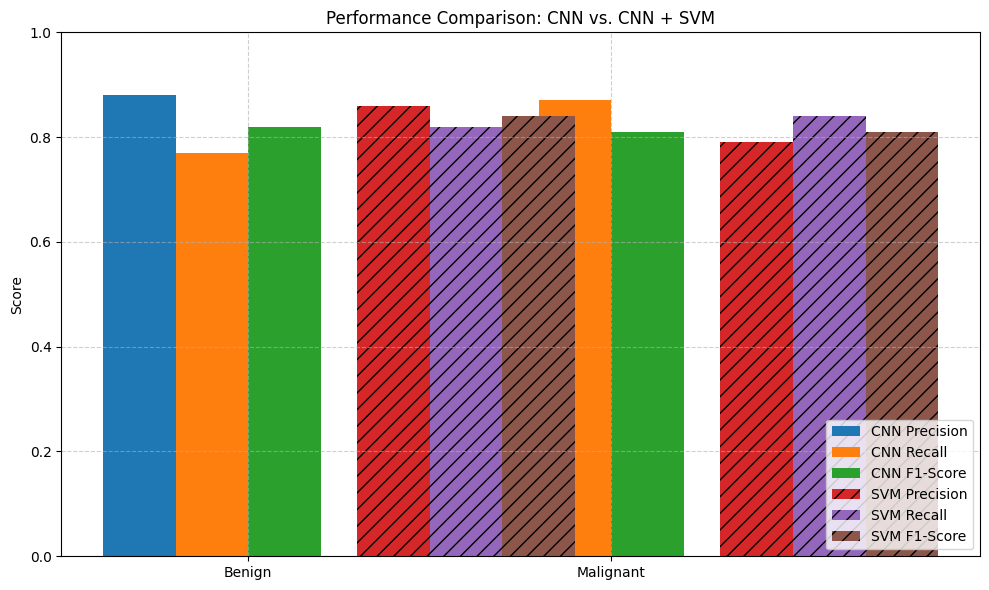

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

classes = ['Benign', 'Malignant']
cnn_precision = [0.88, 0.76]
cnn_recall = [0.77, 0.87]
cnn_f1 = [0.82, 0.81]

svm_precision = [0.86, 0.79]
svm_recall = [0.82, 0.84]
svm_f1 = [0.84, 0.81]

x = np.arange(len(classes))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, cnn_precision, width, label='CNN Precision')
ax.bar(x, cnn_recall, width, label='CNN Recall')
ax.bar(x + width, cnn_f1, width, label='CNN F1-Score')


ax.bar(x + 2*width + 0.1, svm_precision, width, label='SVM Precision', hatch='//')
ax.bar(x + 3*width + 0.1, svm_recall, width, label='SVM Recall', hatch='//')
ax.bar(x + 4*width + 0.1, svm_f1, width, label='SVM F1-Score', hatch='//')


ax.set_ylabel('Score')
ax.set_title('Performance Comparison: CNN vs. CNN + SVM')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1)
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


ResNet50 Model


In [ ]:
#calebs work
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm


IMG_SIZE = 224
EPOCHS = 5
BATCH_SIZE = 32

dataset_path = '/content/drive/MyDrive/Skin Cancer'

# Load and Preprocess Images
def load_images(base_dir):
    images, labels = [], []
    for label in ['benign', 'malignant']:
        path = os.path.join(base_dir, label)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    img = preprocess_input(img)  # Use ResNet preprocessing
                    images.append(img)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

train_images, train_labels = load_images(os.path.join(dataset_path, 'train'))
test_images, test_labels = load_images(os.path.join(dataset_path, 'test'))

le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
test_labels_enc = le.transform(test_labels)

train_labels_cat = to_categorical(train_labels_enc)
test_labels_cat = to_categorical(test_labels_enc)

#Load ResNet50 + Add Classifier Head
def build_resnet50():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Freeze base ResNet50 layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', name='feature_layer')(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = build_resnet50()
resnet_model.fit(train_images, train_labels_cat, validation_data=(test_images, test_labels_cat), epochs=EPOCHS, batch_size=BATCH_SIZE)

# Feature Extraction and Training
feature_extractor = Model(inputs=resnet_model.input, outputs=resnet_model.get_layer('feature_layer').output)
X_train_feat = feature_extractor.predict(train_images)
X_test_feat = feature_extractor.predict(test_images)

svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_feat, train_labels_enc)
svm_preds = svm.predict(X_test_feat)

# Evaluation
print("SVM Classification Report:")
print(classification_report(test_labels_enc, svm_preds))

print("SVM Confusion Matrix:")
print(confusion_matrix(test_labels_enc, svm_preds))

probs = svm.predict_proba(X_test_feat)[:, 1]
print("ROC AUC (SVM):", roc_auc_score(test_labels_enc, probs))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.7269 - loss: 0.8148 - val_accuracy: 0.8500 - val_loss: 0.3533
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8550 - loss: 0.3507 - val_accuracy: 0.8409 - val_loss: 0.3171
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8575 - loss: 0.3256 - val_accuracy: 0.8591 - val_loss: 0.2918
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8595 - loss: 0.3154 - val_accuracy: 0.8682 - val_loss: 0.3054
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8739 - loss: 0.2698 - val_accuracy: 0.8727 - val_loss: 0.2900
83/83 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       360
           1       0.84      0.89      0.86       300

    accuracy                           0.87       

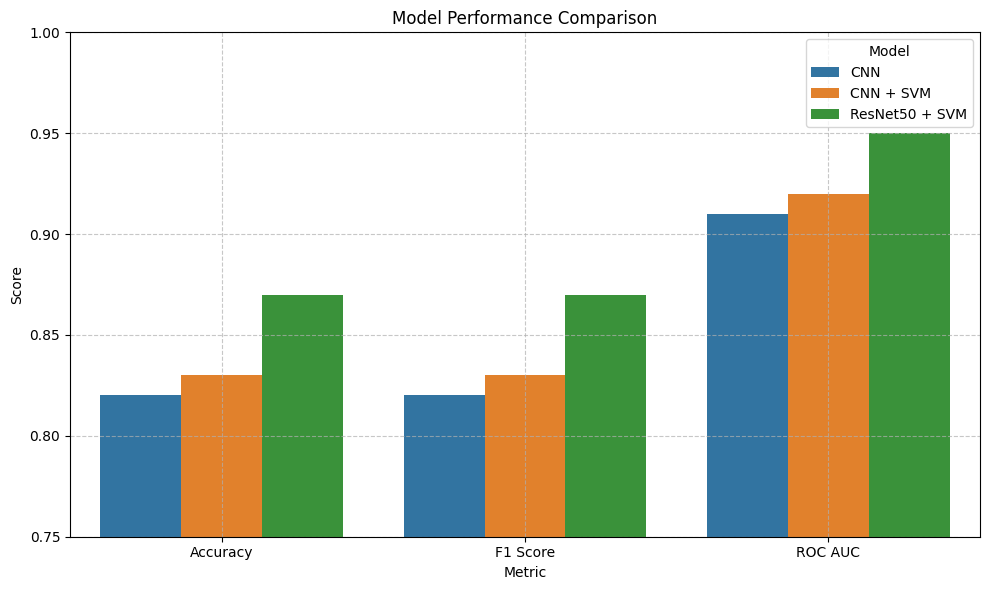

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

models = ['CNN', 'CNN + SVM', 'ResNet50 + SVM']
accuracy = [0.82, 0.83, 0.87]
f1_score = [0.82, 0.83, 0.87]
roc_auc = [0.91, 0.92, 0.95]
data = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'F1 Score': f1_score,
    'ROC AUC': roc_auc
})


data_melted = pd.melt(data, id_vars='Model', var_name='Metric', value_name='Score')


plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=data_melted)
plt.title('Model Performance Comparison')
plt.ylim(0.75, 1.0)
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


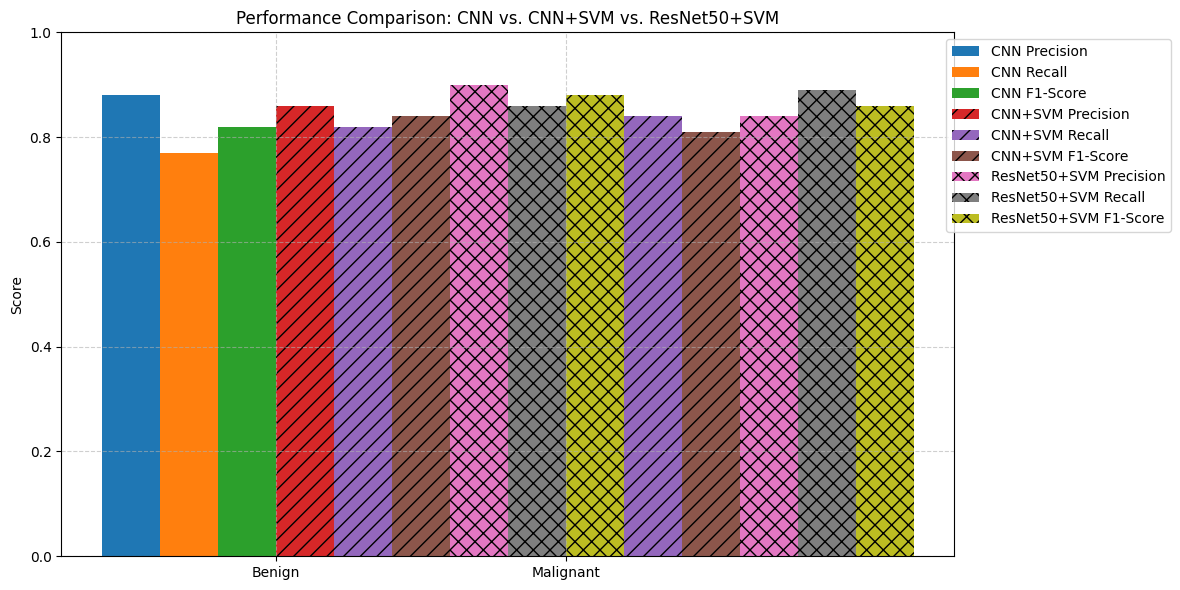

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels
classes = ['Benign', 'Malignant']

# CNN metrics
cnn_precision = [0.88, 0.76]
cnn_recall = [0.77, 0.87]
cnn_f1 = [0.82, 0.81]

# CNN + SVM metrics
svm_precision = [0.86, 0.79]
svm_recall = [0.82, 0.84]
svm_f1 = [0.84, 0.81]

# ResNet50 + SVM metrics
resnet_precision = [0.90, 0.84]
resnet_recall = [0.86, 0.89]
resnet_f1 = [0.88, 0.86]

# Bar plot settings
x = np.arange(len(classes))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

# CNN bars
ax.bar(x - 1.5*width, cnn_precision, width, label='CNN Precision')
ax.bar(x - 0.5*width, cnn_recall, width, label='CNN Recall')
ax.bar(x + 0.5*width, cnn_f1, width, label='CNN F1-Score')

# CNN + SVM bars
ax.bar(x + 1.5*width, svm_precision, width, label='CNN+SVM Precision', hatch='//')
ax.bar(x + 2.5*width, svm_recall, width, label='CNN+SVM Recall', hatch='//')
ax.bar(x + 3.5*width, svm_f1, width, label='CNN+SVM F1-Score', hatch='//')

# ResNet50 + SVM bars
ax.bar(x + 4.5*width, resnet_precision, width, label='ResNet50+SVM Precision', hatch='xx')
ax.bar(x + 5.5*width, resnet_recall, width, label='ResNet50+SVM Recall', hatch='xx')
ax.bar(x + 6.5*width, resnet_f1, width, label='ResNet50+SVM F1-Score', hatch='xx')

# Formatting
ax.set_ylabel('Score')
ax.set_title('Performance Comparison: CNN vs. CNN+SVM vs. ResNet50+SVM')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
